In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import os

## Get Layout file

In [2]:
Layout = pd.read_excel('K:\CPDiary\Data\BaxtersMVI\TrialLayout.xlsx',index_col='Plot')

In [3]:
NPFiles = []
TDRFiles = []
mydir = 'K:\CPDiary\Data\BaxtersMVI\Soil moisture data'
for file in os.listdir(mydir):
    if file.endswith('.NP1'):
        NPFiles.append(os.path.join(mydir, file))
    if file.endswith('.NP2'):
        NPFiles.append(os.path.join(mydir, file))
    if file.endswith('.TDR'):
        TDRFiles.append(os.path.join(mydir, file))

In [4]:
#Set up blank dataframe to take data
ColumnLables = ['Plot','Date','D7','D6','D5','D4','D3','D2','D1']
TabIndex = pd.MultiIndex.from_arrays([[],[]],names=['Plot','Date'])
SoilWaterData = pd.DataFrame(columns=ColumnLables[2:],index = TabIndex)
#Read each file
for ObsTable in NPFiles:
    #Read in file and find which lines have legit data
    HeaderRowsToSkip = 29
    DataTab = pd.read_csv(ObsTable,skiprows = range(HeaderRowsToSkip),header=None,delim_whitespace=True)
    DataTab.dropna(inplace=True)
    DataTab.drop([0,1,3,5],axis=1,inplace=True)
    DataTab.columns = ColumnLables
    DataTab.ix[:,1] = pd.to_datetime(DataTab.ix[:,1],format='%m/%d/%y')
    SoilWaterData = SoilWaterData.append(DataTab)
SoilWaterData.ix[:,'Plot'] = np.int64(SoilWaterData.ix[:,'Plot'] )
SoilWaterData = SoilWaterData.where(SoilWaterData.ix[:,'Plot']<25).dropna()
SoilWaterData.ix[:,'Zone'] = [Layout.ix[int(x),'Zone'] for x in SoilWaterData.Plot]
SoilWaterData.ix[:,'Irrig'] = [Layout.ix[int(x),'Irrig'] for x in SoilWaterData.Plot]
SoilWaterData.ix[:,'Rep'] = [Layout.ix[int(x),'Rep'] for x in SoilWaterData.Plot]
SoilWaterData.set_index(['Plot','Date'],inplace=True,drop=False)

#Add in the TDR Data
SoilWaterData.ix[:,'D0'] = np.nan
for TDRTable in TDRFiles:
    TDRData = pd.read_csv(TDRTable,header=None).ix[:,[2,11,3]]
    TDRData.columns = ['Plot','Date','D0']
    TDRData = TDRData.drop_duplicates(subset=['Plot','Date'])
    TDRData.ix[:,'Date'] = pd.to_datetime(TDRData.ix[:,'Date'], format = '%d%b%Y')
    TDRData.set_index(['Plot','Date'],inplace=True)
    SoilWaterData.update(TDRData)

In [5]:
Means = SoilWaterData.groupby(by=['Date', 'Zone', 'Irrig']).mean()

In [6]:
FieldCapacity = SoilWaterData.ix[SoilWaterData.Date=='2017-10-04',:].copy()

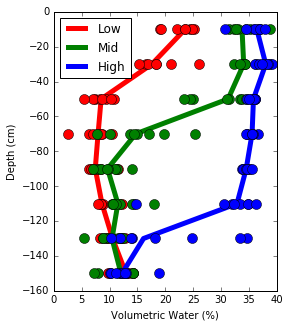

In [7]:
FCGraph, ax = plt.subplots(figsize = (4,5))
pos = 0
cols = ['r','g','b']
for ZoneID in ['Low','Mid','High']:
    ZoneFC = FieldCapacity.ix[FieldCapacity.Zone==ZoneID,['D0','D1','D2','D3','D4','D5','D6','D7']]
    Mean = ZoneFC.median()
    plt.plot(Mean,[-10,-30,-50,-70,-90,-110,-130,-150],lw=5,color=cols[pos],label = ZoneID)
    for plot in ZoneFC.index:
        plt.plot(ZoneFC.ix[plot].values,[-10,-30,-50,-70,-90,-110,-130,-150],'o', color = cols[pos],ms=10)
    pos += 1
plt.ylabel('Depth (cm)')
plt.xlabel('Volumetric Water (%)')
plt.legend(loc=2)

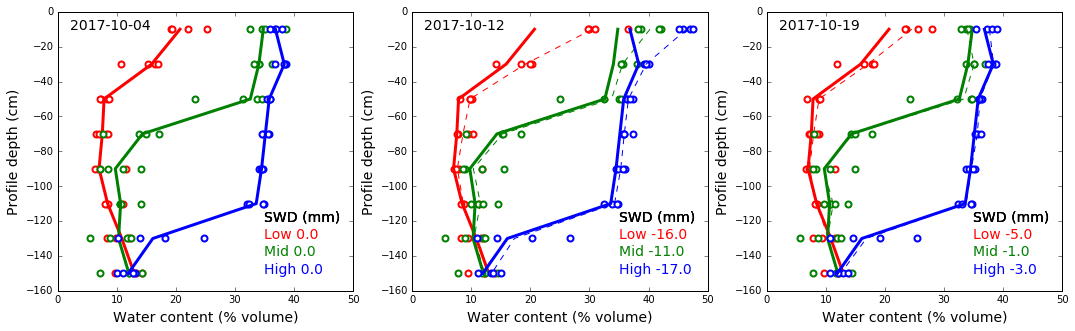

In [8]:
IrrigID = 'STD'
ObsDates = list(SoilWaterData.index.levels[1])
NoObsDates = float(len(ObsDates))
ProfileGraphs = plt.figure(figsize=(18,5))
PlotPos = 1
NoCols = 3.0
NoRows = np.ceil(NoObsDates/NoCols)
for Date in ObsDates:
    fig = ProfileGraphs.add_subplot(NoRows,NoCols,PlotPos)
    PlotPos += 1
    pos = 0
    cols = ['r','g','b']
    yloc = [-130,-140,-150]
    for ZoneID in ['Low','Mid','High']:
        Filter = (SoilWaterData.Zone == ZoneID) & (SoilWaterData.Irrig == IrrigID) & (SoilWaterData.Date == Date)
        TreatWC = SoilWaterData.ix[Filter,['D0','D1','D2','D3','D4','D5','D6','D7']]
        for Plot in TreatWC.index:
            plt.plot(TreatWC.ix[Plot],[-10,-30,-50,-70,-90,-110,-130,-150],'o',mec=cols[pos],mfc='w',lw=3,ms=6,mew=2)
        TreatMean = TreatWC.median()
        plt.plot(TreatMean,[-10,-30,-50,-70,-90,-110,-130,-150],'--',color=cols[pos])
        Filter2 = (FieldCapacity.Zone == ZoneID) & (FieldCapacity.Irrig == IrrigID)
        TreatFC = FieldCapacity.ix[Filter2,['D0','D1','D2','D3','D4','D5','D6','D7']]
        MeanFC = TreatFC.median()
        plt.plot(MeanFC,[-10,-30,-50,-70,-90,-110,-130,-150],lw=3,color=cols[pos],label = ZoneID)
        TreatProfileFC = MeanFC.sum()  
        TreatProfileWater = TreatMean.sum()
        TreatSWD = TreatProfileFC  - TreatProfileWater
        label = ZoneID + ' ' + str(round(TreatSWD))
        fig.text(35,-120,'SWD (mm)',fontsize=14)
        fig.text(35,yloc[pos],label,fontsize=14,color=cols[pos])
        pos +=1
    plt.xlim(0,50)
    plt.ylabel('Profile depth (cm)',fontsize=14)
    plt.xlabel('Water content (% volume)',fontsize=14)
    plt.text(2,-10,Date.date(),fontsize = 14)


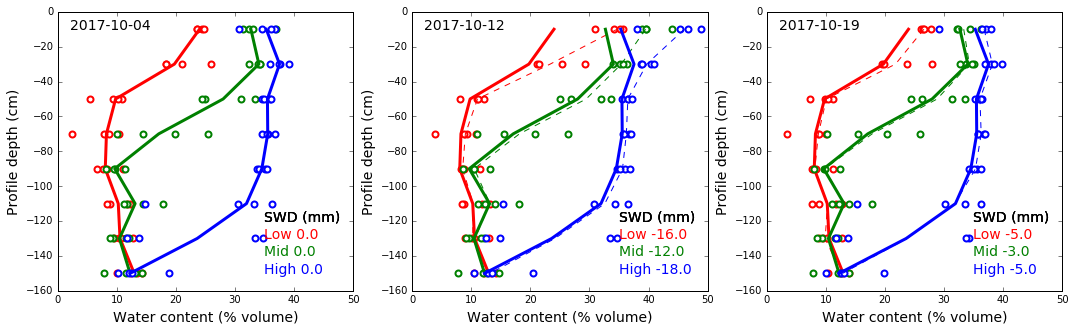

In [9]:
IrrigID = 'VRI'
ObsDates = list(SoilWaterData.index.levels[1])
NoObsDates = float(len(ObsDates))
ProfileGraphs = plt.figure(figsize=(18,5))
PlotPos = 1
NoCols = 3.0
NoRows = np.ceil(NoObsDates/NoCols)
for Date in ObsDates:
    fig = ProfileGraphs.add_subplot(NoRows,NoCols,PlotPos)
    PlotPos += 1
    pos = 0
    cols = ['r','g','b']
    yloc = [-130,-140,-150]
    for ZoneID in ['Low','Mid','High']:
        Filter = (SoilWaterData.Zone == ZoneID) & (SoilWaterData.Irrig == IrrigID) & (SoilWaterData.Date == Date)
        TreatWC = SoilWaterData.ix[Filter,['D0','D1','D2','D3','D4','D5','D6','D7']]
        for Plot in TreatWC.index:
            plt.plot(TreatWC.ix[Plot],[-10,-30,-50,-70,-90,-110,-130,-150],'o',mec=cols[pos],mfc='w',lw=3,ms=6,mew=2)
        TreatMean = TreatWC.median()
        plt.plot(TreatMean,[-10,-30,-50,-70,-90,-110,-130,-150],'--',color=cols[pos])
        Filter2 = (FieldCapacity.Zone == ZoneID) & (FieldCapacity.Irrig == IrrigID)
        TreatFC = FieldCapacity.ix[Filter2,['D0','D1','D2','D3','D4','D5','D6','D7']]
        MeanFC = TreatFC.median()
        plt.plot(MeanFC,[-10,-30,-50,-70,-90,-110,-130,-150],lw=3,color=cols[pos],label = ZoneID)
        TreatProfileFC = MeanFC.sum()  
        TreatProfileWater = TreatMean.sum()
        TreatSWD = TreatProfileFC  - TreatProfileWater
        label = ZoneID + ' ' + str(round(TreatSWD))
        fig.text(35,-120,'SWD (mm)',fontsize=14)
        fig.text(35,yloc[pos],label,fontsize=14,color=cols[pos])
        pos +=1
    plt.xlim(0,50)
    plt.ylabel('Profile depth (cm)',fontsize=14)
    plt.xlabel('Water content (% volume)',fontsize=14)
    plt.text(2,-10,Date.date(),fontsize = 14)
